# Bag of Words Model

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pandas as pd
import random

## Bag of Words Experiment

### Loading Data and Dictionary

In [2]:
checkSpecialChar = lambda s: re.match(r"^[A-Za-z]+$", s) is not None
text_file = open('data/first_name.txt').read().splitlines()
text_file = [x.lower() for x in text_file if isinstance(x, str) and checkSpecialChar(x)]
csv_names = [x for x in pd.read_csv('data/Indian_names.csv')['Name'] if isinstance(x, str) and checkSpecialChar(x)]
words = text_file + csv_names
words = list(set(words))
len(words)

7904

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Parameters

In [4]:
g = torch.Generator().manual_seed(2147483647)
block_size = 3
embed_size = 10
batch_size = 64
vocab_size = len(words)
chars_size = len(itos)
hidden_size = 100

### Build Dataset

In [5]:
def build_dataset(words):    
    X, Y = [], []
    for word in words:
        # print(word) 
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[ix] for ix in context]), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([47054, 3]) torch.Size([47054])
torch.Size([5890, 3]) torch.Size([5890])
torch.Size([5767, 3]) torch.Size([5767])


### Custom Layers

In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
       self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
       self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim = 0, keepdim = True)
            xvar = x.var(dim = 0, unbiased = True, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

### Model Initialization

In [7]:
C = torch.randn((chars_size, embed_size), generator=g)
layers = [
    Linear(embed_size * block_size, hidden_size), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, chars_size), BatchNorm1D(chars_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

47551


### Training

In [8]:
def train(X, Y, num_epochs=100000):
    losses = []
    for i in range(num_epochs):
        # Minibatch generation
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]

        # Forward Pass
        emb = C[Xb]
        x = emb.view(-1, embed_size * block_size)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)

        # Backward Pass
        for layer in layers:
            layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        # update weights
        lr = 0.1 if i < 50000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
            
        losses.append(loss.log10().item())

        # track stats
        if i % 10000 == 0:
            print(f"{i:7d} / {num_epochs:7d}: {loss.item():.4f}")
    return losses

      0 /  100000: 3.3038
  10000 /  100000: 1.8582
  20000 /  100000: 1.9548
  30000 /  100000: 1.8339
  40000 /  100000: 2.1158
  50000 /  100000: 1.8041
  60000 /  100000: 1.8736
  70000 /  100000: 1.8309
  80000 /  100000: 1.8629
  90000 /  100000: 2.0792


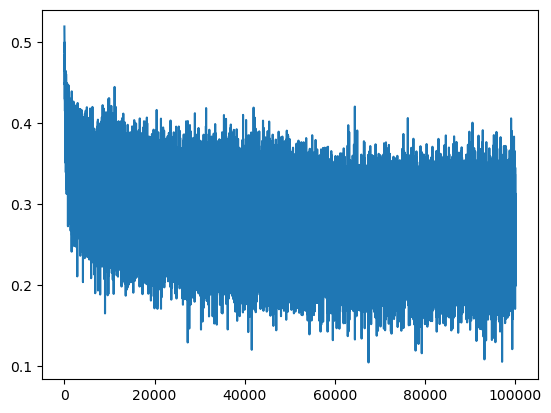

In [9]:
losses = train(Xtr, Ytr)
plt.plot(losses)

### Model Statistics

Layer 2 Tanh 0.00 0.69 13.28%
Layer 5 Tanh 0.02 0.72 14.75%
Layer 8 Tanh -0.01 0.75 15.02%
Layer 11 Tanh -0.01 0.76 14.77%
Layer 14 Tanh -0.02 0.79 18.08%


Text(0.5, 1.0, 'Tanh Activations Distribution')

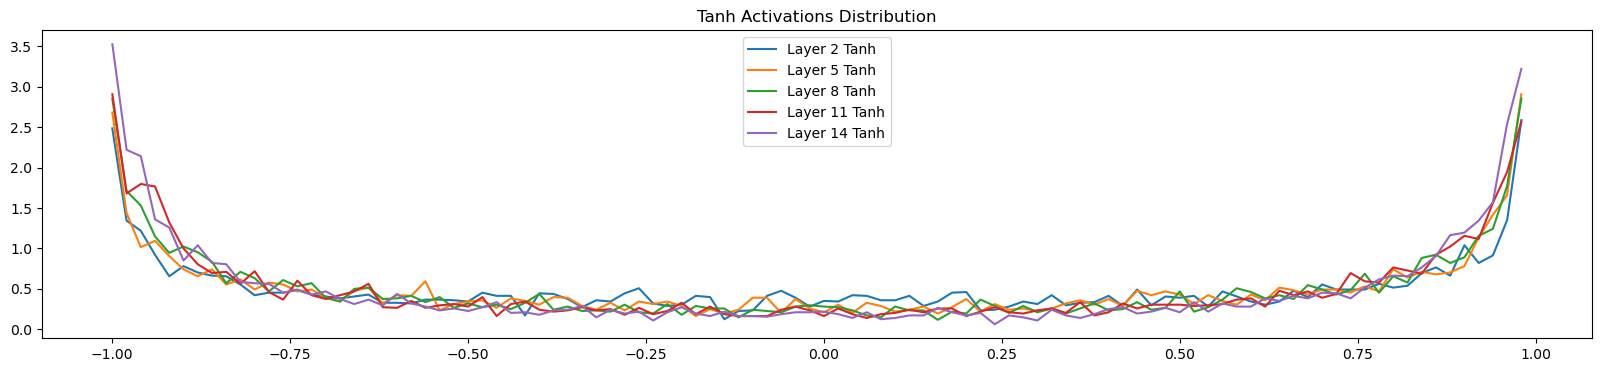

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for idx, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {idx} {layer.__class__.__name__} {t.mean():.2f} {t.std():.2f} {((t.abs() > 0.97).float().mean() * 100):.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {idx} {layer.__class__.__name__}")
plt.legend(legends);
plt.title("Tanh Activations Distribution")

Layer 2 Tanh 0.000000 3.645871e-03
Layer 5 Tanh 0.000000 3.484821e-03
Layer 8 Tanh -0.000000 3.417758e-03
Layer 11 Tanh -0.000000 3.178530e-03
Layer 14 Tanh 0.000000 3.191134e-03


Text(0.5, 1.0, 'Tanh Activations Gradient Distribution')

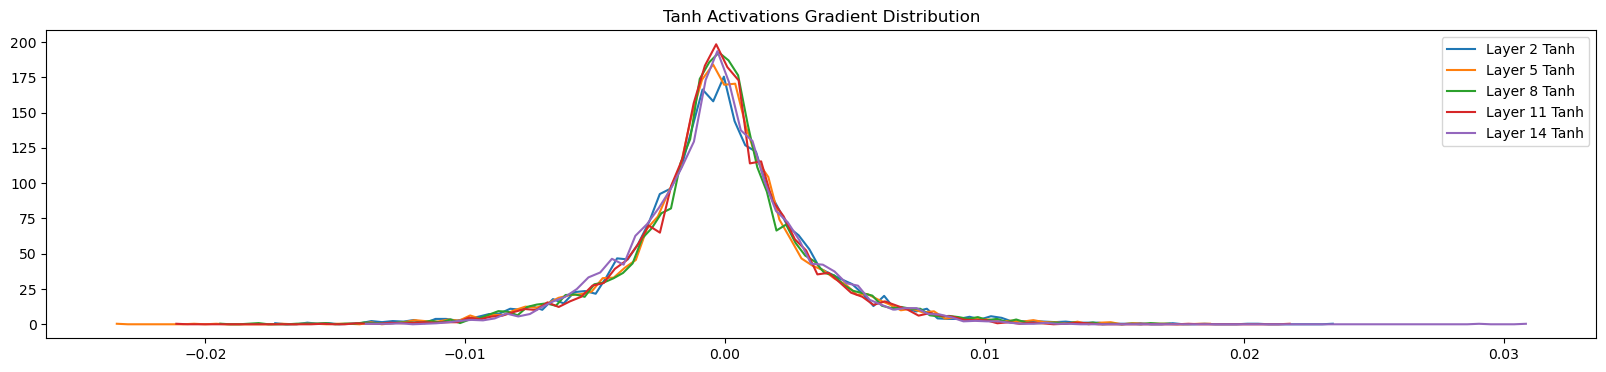

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for idx, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {idx} {layer.__class__.__name__} {t.mean():f} {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {idx} {layer.__class__.__name__}")
plt.legend(legends);
plt.title("Tanh Activations Gradient Distribution")

Weight (27, 10) 0.000000 1.769585e-02 grad:data ratio 1.702995e-02
Weight (30, 100) -0.000116 1.221699e-02 grad:data ratio 3.293989e-02
Weight (100, 100) -0.000000 9.096709e-03 grad:data ratio 4.086185e-02
Weight (100, 100) 0.000013 9.243938e-03 grad:data ratio 4.178943e-02
Weight (100, 100) -0.000045 8.797553e-03 grad:data ratio 4.037659e-02
Weight (100, 100) 0.000058 7.592732e-03 grad:data ratio 3.617083e-02
Weight (100, 27) 0.000013 1.353550e-02 grad:data ratio 4.799797e-02


Text(0.5, 1.0, 'Parameter Gradient Distributions')

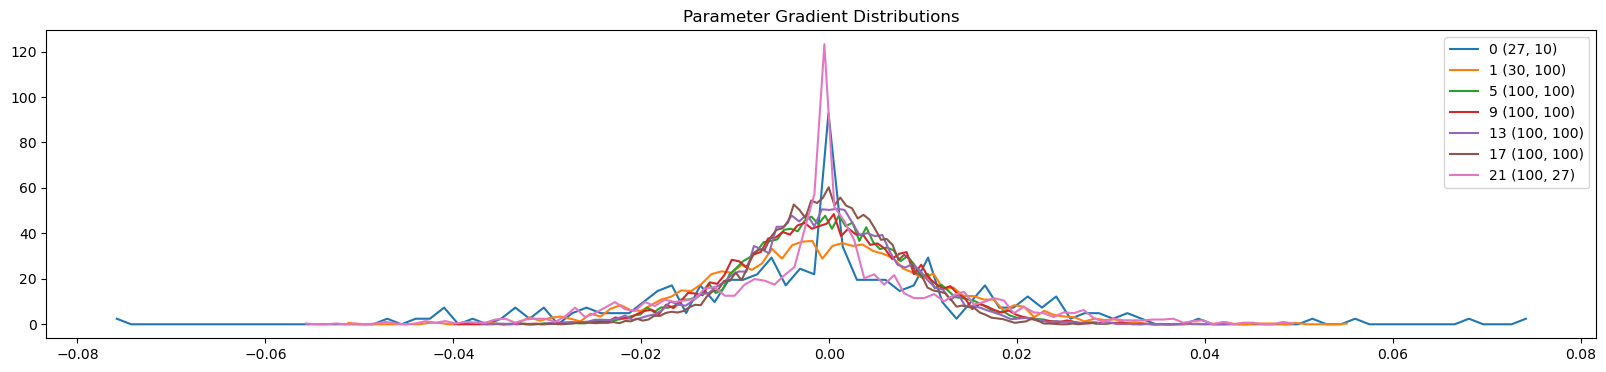

In [15]:
plt.figure(figsize=(20, 4))
legends = []
for idx, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"Weight {tuple(p.shape)} {t.mean():f} {t.std():e} grad:data ratio {(t.std() / p.std()):e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{idx} {tuple(p.shape)}")
plt.legend(legends);
plt.title("Parameter Gradient Distributions")

### Evaluation

In [16]:
@torch.no_grad()
def split_loss(split): 
    X, Y = {
        "train": (Xtr, Ytr),
        "val": (Xva, Yva),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    x = emb.view(-1, embed_size * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(split, loss.item())

for layer in layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False

split_loss("train")
split_loss("val")

train 1.7848055362701416
val 2.1428146362304688


### Next Word Generation

In [18]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join([itos[i] for i in out]))

mohanimya.
haren.
nihoyal.
rehma.
jendra.
guldeep.
seli.
jami.
pen.
akeem.
surajitephendrakashi.
shubhrishimansh.
jair.
jay.
panchu.
foukamand.
rupender.
harima.
muskkura.
him.


## Character Embedding Visualization

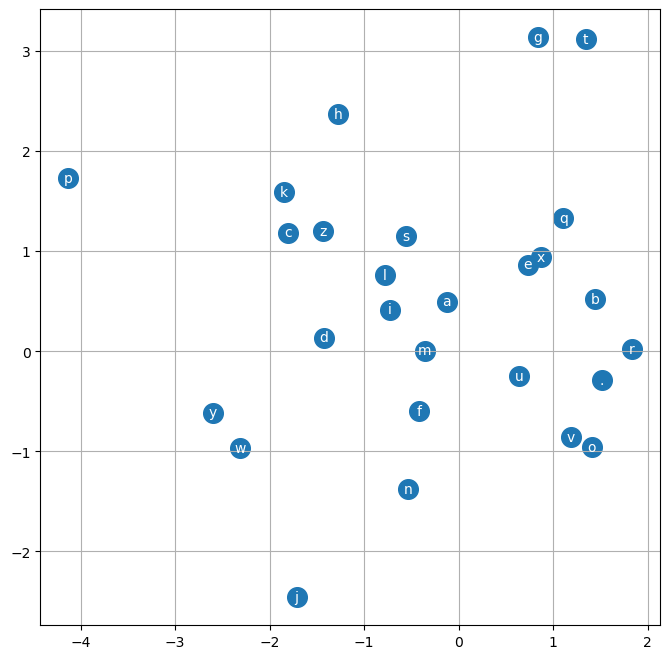

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')